# Imports

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
from prophet import Prophet

# Utils

In [165]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.2)
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title("Actual vs. Predicted Prices")
    plt.grid(True)

    # Add the y=x line
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)

    plt.show()

# Data Manipulation

In [128]:
df = pd.read_csv('Datasets\\Data_Train.csv')
df.sample(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
2170,GoAir,6/06/2019,Delhi,Cochin,DEL ? BOM ? COK,10:35,19:35,9h,1 stop,No info,4959
181,Jet Airways,27/03/2019,Mumbai,Hyderabad,BOM ? HYD,19:35,21:05,1h 30m,non-stop,No info,5678
5964,Air Asia,01/03/2019,Banglore,New Delhi,BLR ? DEL,05:50,08:40,2h 50m,non-stop,No info,10715
6751,SpiceJet,9/03/2019,Kolkata,Banglore,CCU ? BLR,22:20,00:40 10 Mar,2h 20m,non-stop,No info,4622
10068,SpiceJet,21/06/2019,Banglore,Delhi,BLR ? DEL,09:30,12:20,2h 50m,non-stop,No info,3625


In [129]:
holiday_df = pd.read_csv('Datasets\\2019.csv')
holiday_df.sample(5)

,date,day,holiday,holiday_type
32,2019-10-06,Sunday,Dussehra (Maha Ashtami) (Additional) (R),Restricted
25,2019-08-17,Saturday,Parsi New Year's day/ Nauraj (R),Restricted
45,2019-12-25,Wednesday,Christmas Day (G),Gazetted
17,2019-04-21,Sunday,Easter Sunday (R),Restricted
30,2019-10-02,Wednesday,Mahatma Gandhi's Birthday (G),Gazetted


In [130]:
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], dayfirst=True, errors='raise')
df['journey_dow'] = df['Date_of_Journey'].dt.dayofweek
df['journey_month'] = df['Date_of_Journey'].dt.month
df['journey_dom'] = df['Date_of_Journey'].dt.day
df['is_weekend'] = (df['journey_dow'] >= 5).astype(int)
df.sample(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_dow,journey_month,journey_dom,is_weekend
6349,Multiple carriers,2019-06-27,Delhi,Cochin,DEL ? BOM ? COK,08:45,19:15,10h 30m,1 stop,No info,8266,3,6,27,0
9174,Jet Airways,2019-03-21,Mumbai,Hyderabad,BOM ? HYD,19:35,21:05,1h 30m,non-stop,No info,5678,3,3,21,0
2706,IndiGo,2019-03-01,Chennai,Kolkata,MAA ? CCU,05:15,07:35,2h 20m,non-stop,No info,7295,4,3,1,0
3270,Jet Airways,2019-06-12,Delhi,Cochin,DEL ? BOM ? COK,21:50,04:25 13 Jun,6h 35m,1 stop,No info,14714,2,6,12,0
350,Jet Airways,2019-04-27,Banglore,Delhi,BLR ? DEL,06:00,08:45,2h 45m,non-stop,In-flight meal not included,4544,5,4,27,1


In [131]:
hol_col = 'date'
holiday_df[hol_col] = pd.to_datetime(holiday_df[hol_col], errors='coerce', dayfirst=True)
holiday_dates = set(holiday_df[hol_col].dt.normalize().dropna().unique())

# Create is_holiday (1 = holiday, 0 = not)
df['is_holiday'] = df['Date_of_Journey'].dt.normalize().isin(holiday_dates).astype(int)
df.sample(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_dow,journey_month,journey_dom,is_weekend,is_holiday
6274,Jet Airways,2019-06-12,Delhi,Cochin,DEL ? BOM ? COK,11:30,04:25 13 Jun,16h 55m,1 stop,In-flight meal not included,10262,2,6,12,0,0
2287,Jet Airways,2019-03-24,Kolkata,Banglore,CCU ? BOM ? BLR,16:55,16:20 25 Mar,23h 25m,1 stop,No info,14231,6,3,24,1,0
10308,Air India,2019-06-06,Kolkata,Banglore,CCU ? MAA ? BLR,14:35,14:35 07 Jun,24h,1 stop,No info,6528,3,6,6,0,0
8818,IndiGo,2019-05-15,Kolkata,Banglore,CCU ? MAA ? BLR,17:35,22:15,4h 40m,1 stop,No info,5386,2,5,15,0,0
7861,SpiceJet,2019-04-18,Kolkata,Banglore,CCU ? BLR,22:20,00:40 19 Apr,2h 20m,non-stop,No info,4174,3,4,18,0,0


In [132]:
df['is_holiday'].corr(df['Price'])

np.float64(-0.06689061161050358)

In [133]:
df['journey_dow'].corr(df['Price'])

np.float64(0.05161273492289205)

In [134]:
df['journey_month'].corr(df['Price'])

np.float64(-0.10365053528028771)

In [135]:
df['journey_dom'].corr(df['Price'])

np.float64(-0.1537382484712872)

In [136]:
df['is_weekend'].corr(df['Price'])

np.float64(0.020295432446696238)

In [137]:
df.drop(columns=['Date_of_Journey'], inplace=True)
df.sample(5)

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_dow,journey_month,journey_dom,is_weekend,is_holiday
9438,Air India,Delhi,Cochin,DEL ? COK,14:10,17:10,3h,non-stop,No info,6094,3,5,9,0,0
2343,Air India,Delhi,Cochin,DEL ? HYD ? MAA ? COK,09:45,09:25 16 May,23h 40m,2 stops,No info,10975,2,5,15,0,0
8075,Jet Airways,Banglore,Delhi,BLR ? DEL,06:00,08:45,2h 45m,non-stop,No info,7229,0,5,27,0,0
3738,Jet Airways,Banglore,New Delhi,BLR ? BOM ? DEL,08:55,09:30 07 Mar,24h 35m,1 stop,No info,17261,2,3,6,0,0
9902,Vistara,Kolkata,Banglore,CCU ? DEL ? BLR,20:20,20:20 25 May,24h,1 stop,No info,9345,4,5,24,0,0


<Axes: xlabel='Airline'>

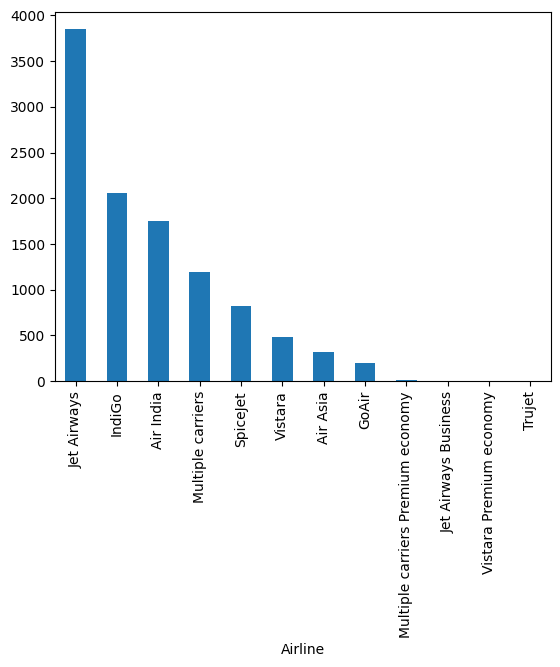

In [138]:
df.Airline.value_counts().plot(kind='bar')

In [139]:
# freq_series = df['Airline'].value_counts(normalize=True)
# rare = freq_series[freq_series < 0.01].index
# df['Airline'] = df['Airline'].where(~df['Airline'].isin(rare), 'Other')
# df.Airline.value_counts().plot(kind='bar')

<Axes: ylabel='Airline'>

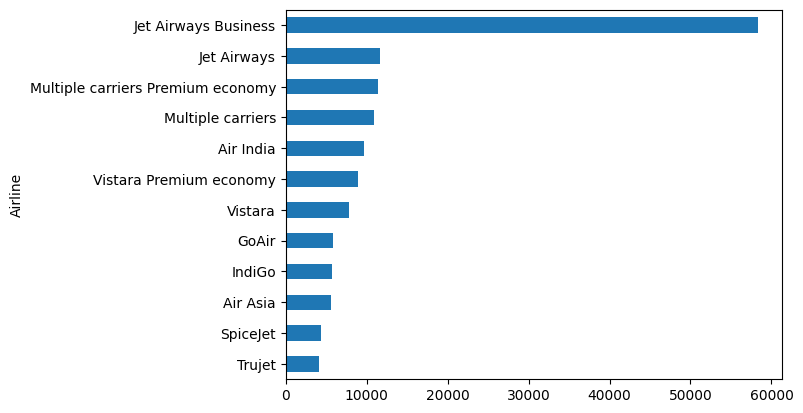

In [140]:
df.groupby('Airline')['Price'].mean().sort_values().plot(kind='barh')

In [141]:
# ...existing code...
# Assign airline labels in (0,1) scaled by average price
airline_mean = df.groupby('Airline')['Price'].mean()
amin, amax = airline_mean.min(), airline_mean.max()
if amin == amax:
    airline_scaled_map = {a: 0.5 for a in airline_mean.index}
else:
    airline_scaled_map = {a: (v - amin) / (amax - amin) for a, v in airline_mean.items()}
df['Airline_price_scaled'] = df['Airline'].map(airline_scaled_map)

print("Airline scaled mapping:", airline_scaled_map)
df.sample(50)
# ...existing code...

Airline scaled mapping: {'Air Asia': np.float64(0.026748355820033223), 'Air India': np.float64(0.10091009153867715), 'GoAir': np.float64(0.031742881314509044), 'IndiGo': np.float64(0.02828699039203006), 'Jet Airways': np.float64(0.13840110460203184), 'Jet Airways Business': np.float64(1.0), 'Multiple carriers': np.float64(0.12472970121567269), 'Multiple carriers Premium economy': np.float64(0.13424981839918887), 'SpiceJet': np.float64(0.0036571323727829456), 'Trujet': np.float64(0.0), 'Vistara': np.float64(0.06743708150341081), 'Vistara Premium economy': np.float64(0.08894230769230771)}


,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_dow,journey_month,journey_dom,is_weekend,is_holiday,Airline_price_scaled
7249,Air India,Delhi,Cochin,DEL ? RPR ? NAG ? BOM ? COK,05:15,07:40 02 Jun,26h 25m,3 stops,No info,12383,5,6,1,1,0,0.100910
6204,Vistara,Chennai,Kolkata,MAA ? CCU,07:05,09:20,2h 15m,non-stop,No info,3687,3,5,9,0,0,0.067437
1451,IndiGo,Delhi,Cochin,DEL ? BOM ? COK,10:45,01:35 22 Mar,14h 50m,1 stop,No info,7318,3,3,21,0,0,0.028287
3540,Jet Airways,Delhi,Cochin,DEL ? JAI ? BOM ? COK,09:40,12:35 10 Jun,26h 55m,2 stops,In-flight meal not included,10368,6,6,9,1,0,0.138401
1087,IndiGo,Mumbai,Hyderabad,BOM ? HYD,20:05,21:40,1h 35m,non-stop,No info,2227,5,5,18,1,0,0.028287
7086,Jet Airways,Delhi,Cochin,DEL ? BOM ? COK,22:50,19:00 22 May,20h 10m,1 stop,In-flight meal not included,12898,1,5,21,0,0,0.138401
3462,Air India,Delhi,Cochin,DEL ? MAA ? COK,12:30,09:25 16 May,20h 55m,1 stop,No info,7480,2,5,15,0,0,0.100910
5984,Jet Airways,Delhi,Cochin,DEL ? BOM ? COK,15:00,19:00 04 Jun,28h,1 stop,No info,14714,0,6,3,0,0,0.138401
9851,Air India,Banglore,Delhi,BLR ? DEL,13:20,16:10,2h 50m,non-stop,No info,5911,0,4,1,0,0,0.100910
1602,Jet Airways,Delhi,Cochin,DEL ? ATQ ? BOM ? COK,20:00,04:25 19 May,8h 25m,2 stops,In-flight meal not included,15318,5,5,18,1,0,0.138401


In [142]:
df.drop(columns=['Airline'], inplace=True)
df.sample(5)

,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_dow,journey_month,journey_dom,is_weekend,is_holiday,Airline_price_scaled
7715,Kolkata,Banglore,CCU ? BOM ? BLR,06:30,08:15 02 Apr,25h 45m,1 stop,In-flight meal not included,7064,0,4,1,0,0,0.138401
10406,Delhi,Cochin,DEL ? AMD ? BOM ? COK,16:40,19:15 07 Mar,26h 35m,2 stops,No info,12646,2,3,6,0,0,0.100910
7460,Banglore,New Delhi,BLR ? DEL,13:00,15:50,2h 50m,non-stop,No info,5694,6,3,24,1,0,0.028287
6938,Kolkata,Banglore,CCU ? DEL ? BLR,07:35,19:25,11h 50m,1 stop,No info,5192,2,6,12,0,0,0.026748
3318,Delhi,Cochin,DEL ? BOM ? COK,08:00,21:00,13h,1 stop,No info,13587,5,6,1,1,0,0.124730


In [143]:
df['Airline_price_scaled'].corr(df['Price'])

np.float64(0.6410038927415176)

<Axes: xlabel='Total_Stops'>

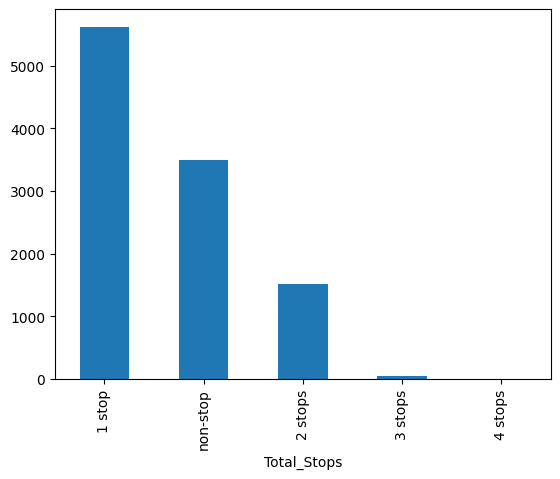

In [144]:
df.Total_Stops.value_counts().plot(kind='bar')

In [145]:
stop_map = {'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4}
df['Total_Stops'] = df['Total_Stops'].map(stop_map).fillna(4).astype(int)
df.sample(5)

,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_dow,journey_month,journey_dom,is_weekend,is_holiday,Airline_price_scaled
6150,Kolkata,Banglore,CCU ? BOM ? BLR,16:50,18:30 02 Apr,25h 40m,1,No info,7893,0,4,1,0,0,0.100910
9614,Banglore,New Delhi,BLR ? BOM ? DEL,08:00,10:25 13 Mar,26h 25m,1,In-flight meal not included,11087,5,3,9,1,0,0.138401
7656,Delhi,Cochin,DEL ? BOM ? COK,16:00,21:00,5h,1,No info,6593,5,6,1,1,0,0.028287
4476,Banglore,New Delhi,BLR ? BOM ? DEL,08:00,07:40 19 Mar,23h 40m,1,In-flight meal not included,7832,3,3,21,0,0,0.138401
939,Delhi,Cochin,DEL ? BDQ ? BOM ? COK,18:25,04:25 07 Jun,10h,2,No info,14237,3,6,6,0,0,0.138401


In [146]:
df['Total_Stops'].corr(df['Price'])

np.float64(0.6031158554997769)

In [147]:
# ...existing code...
from sklearn.model_selection import KFold
TARGET = 'Price'
SRC_COL = 'Source'
DST_COL = 'Destination'

# (Optional) rare grouping (threshold 1% of rows)
for col in [SRC_COL, DST_COL]:
    freq = df[col].value_counts(normalize=True)
    rare_vals = freq[freq < 0.01].index
    df[col] = df[col].where(~df[col].isin(rare_vals), 'Other')

# Frequency counts
df[f'{SRC_COL}_freq'] = df[SRC_COL].map(df[SRC_COL].value_counts())
df[f'{DST_COL}_freq'] = df[DST_COL].map(df[DST_COL].value_counts())

# Degree (unique partner counts)
src_out_deg = df.groupby(SRC_COL)[DST_COL].nunique()
dst_in_deg  = df.groupby(DST_COL)[SRC_COL].nunique()
df[f'{SRC_COL}_out_deg'] = df[SRC_COL].map(src_out_deg)
df[f'{DST_COL}_in_deg']  = df[DST_COL].map(dst_in_deg)

# Route feature (directional)
df['Route'] = df[SRC_COL] + '_' + df[DST_COL]
df['Route_freq'] = df['Route'].map(df['Route'].value_counts())

# Out-of-fold mean encodings (Source, Destination, Route)
def oof_mean_encode(frame, col, target, n_splits=5, seed=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    global_mean = frame[target].mean()
    oof_series = pd.Series(index=frame.index, dtype=float)
    for tr_idx, va_idx in kf.split(frame):
        tr, va = frame.iloc[tr_idx], frame.iloc[va_idx]
        means = tr.groupby(col)[target].mean()
        oof_series.iloc[va_idx] = frame.iloc[va_idx][col].map(means).fillna(global_mean)
    # Final mapping (fit on full data) for later inference
    full_map = frame.groupby(col)[target].mean().to_dict()
    return oof_series, full_map, global_mean

for feature_col in [SRC_COL, DST_COL, 'Route']:
    df[f'{feature_col}_te'], _map, _gm = oof_mean_encode(df, feature_col, TARGET)
    # Store mapping dicts if needed for test inference
    # e.g. save in a dict: mean_encoding_maps[feature_col] = (_map, _gm)

# Example list of new engineered columns
engineered_cols = [
    f'{SRC_COL}_freq', f'{DST_COL}_freq',
    f'{SRC_COL}_out_deg', f'{DST_COL}_in_deg',
    'Route_freq',
    f'{SRC_COL}_te', f'{DST_COL}_te', 'Route_te'
]
print("Engineered Source/Destination features:", engineered_cols)
df[engineered_cols].head()
# ...existing code...

Engineered Source/Destination features: ['Source_freq', 'Destination_freq', 'Source_out_deg', 'Destination_in_deg', 'Route_freq', 'Source_te', 'Destination_te', 'Route_te']


,Source_freq,Destination_freq,Source_out_deg,Destination_in_deg,Route_freq,Source_te,Destination_te,Route_te
0,2197,932,2,1,932,7941.264491,11696.469737,11696.469737
1,2871,2871,1,1,2871,9124.061685,9124.061685,9124.061685
2,4537,4537,1,1,4537,10544.295941,10544.295941,10544.295941
3,2871,2871,1,1,2871,9190.719291,9190.719291,9190.719291
4,2197,932,2,1,932,8052.396562,12112.617166,12112.617166


In [148]:
df.sample(5)

,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_dow,...,is_holiday,Airline_price_scaled,Source_freq,Destination_freq,Source_out_deg,Destination_in_deg,Route_freq,Source_te,Destination_te,Route_te
1664,Kolkata,Banglore,Kolkata_Banglore,18:55,20:45 07 Jun,25h 50m,1,No info,14571,3,...,0,0.138401,2871,2871,1,1,2871,9124.061685,9124.061685,9124.061685
1431,Delhi,Cochin,Delhi_Cochin,07:35,12:10,4h 35m,1,No info,5458,3,...,0,0.028287,4537,4537,1,1,4537,10524.495616,10524.495616,10524.495616
680,Delhi,Cochin,Delhi_Cochin,07:05,19:00,11h 55m,1,No info,15554,5,...,0,0.138401,4537,4537,1,1,4537,10524.495616,10524.495616,10524.495616
6264,Banglore,New Delhi,Banglore_New Delhi,08:15,22:55,14h 40m,2,No info,7904,4,...,0,0.100910,2197,932,2,1,932,7940.658619,11793.345430,11793.345430
4721,Kolkata,Banglore,Kolkata_Banglore,09:35,10:55 13 Jun,25h 20m,1,No info,12692,2,...,0,0.138401,2871,2871,1,1,2871,9193.256857,9193.256857,9193.256857


In [149]:
df[engineered_cols].corrwith(df['Price']).sort_values(ascending=False)

c:\Program Files\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Program Files\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Route_te              0.490605
Destination_te        0.490605
Source_te             0.364796
Source_freq           0.355404
Destination_freq      0.320026
Route_freq            0.320026
Source_out_deg       -0.118026
Destination_in_deg         NaN
dtype: float64

In [150]:
df.Destination_in_deg.unique()

array([1])

In [151]:
df.drop(columns=['Destination_in_deg'], inplace=True)
df.sample(5)

,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_dow,...,is_weekend,is_holiday,Airline_price_scaled,Source_freq,Destination_freq,Source_out_deg,Route_freq,Source_te,Destination_te,Route_te
3840,Delhi,Cochin,Delhi_Cochin,07:00,19:15,12h 15m,1,No info,15704,5,...,1,0,0.100910,4537,4537,1,4537,10516.703488,10516.703488,10516.703488
9683,Banglore,New Delhi,Banglore_New Delhi,17:25,10:15 13 Mar,16h 50m,2,No info,12778,1,...,0,0,0.100910,2197,932,2,932,8021.181924,11838.598923,11838.598923
1627,Kolkata,Banglore,Kolkata_Banglore,16:45,21:05 02 May,28h 20m,1,No info,7452,2,...,0,0,0.100910,2871,2871,1,2871,9125.943576,9125.943576,9125.943576
3149,Mumbai,Hyderabad,Mumbai_Hyderabad,10:20,11:50,1h 30m,0,In-flight meal not included,4995,0,...,0,0,0.138401,697,697,1,697,5146.270872,5146.270872,5146.270872
3936,Banglore,New Delhi,Banglore_New Delhi,21:10,00:05 13 Mar,2h 55m,0,No info,7240,5,...,1,0,0.067437,2197,932,2,932,8133.907902,12153.871486,12153.871486


In [152]:
df.drop(columns=['Source', 'Destination', 'Route'], inplace=True)
df.sample(5)

,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_dow,journey_month,journey_dom,is_weekend,is_holiday,Airline_price_scaled,Source_freq,Destination_freq,Source_out_deg,Route_freq,Source_te,Destination_te,Route_te
998,07:30,19:00,11h 30m,1,No info,9315,0,5,27,0,0,0.124730,4537,4537,1,4537,10524.495616,10524.495616,10524.495616
4611,14:05,22:35,8h 30m,1,In-flight meal not included,10844,6,6,9,1,0,0.138401,2871,2871,1,2871,9124.061685,9124.061685,9124.061685
7239,19:30,20:45,1h 15m,0,No info,2575,6,3,24,1,0,0.100910,697,697,1,697,5108.969178,5108.969178,5108.969178
5561,11:45,12:35 13 Jun,24h 50m,2,No info,13882,2,6,12,0,0,0.138401,4537,4537,1,4537,10544.295941,10544.295941,10544.295941
2630,04:40,07:15,2h 35m,0,No info,4804,2,5,1,0,0,0.028287,2871,2871,1,2871,9193.256857,9193.256857,9193.256857


In [153]:
df['departure'] = pd.to_datetime(df['Dep_Time']).dt.hour + pd.to_datetime(df['Dep_Time']).dt.minute / 60
df['arrival'] = pd.to_datetime(df['Arrival_Time']).dt.hour + pd.to_datetime(df['Arrival_Time']).dt.minute / 60
df.sample(5)

C:\Users\user\AppData\Local\Temp\ipykernel_15856\1293404127.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['departure'] = pd.to_datetime(df['Dep_Time']).dt.hour + pd.to_datetime(df['Dep_Time']).dt.minute / 60
C:\Users\user\AppData\Local\Temp\ipykernel_15856\1293404127.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['departure'] = pd.to_datetime(df['Dep_Time']).dt.hour + pd.to_datetime(df['Dep_Time']).dt.minute / 60
C:\Users\user\AppData\Local\Temp\ipykernel_15856\1293404127.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['arrival'] = pd.to_datetime(df[

,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_dow,journey_month,journey_dom,is_weekend,...,Airline_price_scaled,Source_freq,Destination_freq,Source_out_deg,Route_freq,Source_te,Destination_te,Route_te,departure,arrival
4141,19:50,22:50,3h,0,No info,7229,6,5,12,1,...,0.138401,2197,1265,2,1265,7940.658619,5176.532305,5176.532305,19.833333,22.833333
8203,22:10,01:00 28 Jun,2h 50m,0,No info,3419,3,6,27,0,...,0.028287,2197,1265,2,1265,7940.658619,5176.532305,5176.532305,22.166667,1.000000
8186,10:20,21:00,10h 40m,1,No info,6637,2,3,27,0,...,0.124730,4537,4537,1,4537,10524.495616,10524.495616,10524.495616,10.333333,21.000000
2951,03:05,04:25,1h 20m,0,No info,5678,3,3,21,0,...,0.138401,697,697,1,697,4873.456014,4873.456014,4873.456014,3.083333,4.416667
1567,20:40,09:25 28 Jun,12h 45m,1,No info,7480,3,6,27,0,...,0.100910,4537,4537,1,4537,10524.495616,10524.495616,10524.495616,20.666667,9.416667


In [154]:
df.drop(columns=['Dep_Time', 'Arrival_Time'], inplace=True)
df.sample(5)

,Duration,Total_Stops,Additional_Info,Price,journey_dow,journey_month,journey_dom,is_weekend,is_holiday,Airline_price_scaled,Source_freq,Destination_freq,Source_out_deg,Route_freq,Source_te,Destination_te,Route_te,departure,arrival
2128,2h 40m,0,No info,5613,5,4,27,1,0,0.067437,2197,1265,2,1265,7941.264491,5135.014749,5135.014749,7.000000,9.666667
4179,5h 30m,1,In-flight meal not included,12898,5,6,1,1,0,0.138401,4537,4537,1,4537,10516.703488,10516.703488,10516.703488,7.083333,12.583333
3775,26h 50m,1,In-flight meal not included,9663,6,5,12,1,0,0.138401,2871,2871,1,2871,9124.061685,9124.061685,9124.061685,6.500000,9.333333
4787,9h 40m,1,No info,6117,2,5,15,0,0,0.100910,2871,2871,1,2871,9193.256857,9193.256857,9193.256857,19.000000,4.666667
7164,10h 50m,1,In-flight meal not included,6068,2,3,27,0,0,0.138401,4537,4537,1,4537,10516.703488,10516.703488,10516.703488,8.000000,18.833333


In [155]:
corr_colls = ['departure', 'arrival']

df[corr_colls].corrwith(df['Price']).sort_values(ascending=False)

arrival      0.020921
departure    0.005485
dtype: float64

In [156]:
df['duration_mins'] = pd.to_timedelta(df['Duration']).dt.total_seconds() / 60
df.sample(5)

,Duration,Total_Stops,Additional_Info,Price,journey_dow,journey_month,journey_dom,is_weekend,is_holiday,Airline_price_scaled,Source_freq,Destination_freq,Source_out_deg,Route_freq,Source_te,Destination_te,Route_te,departure,arrival,duration_mins
9155,11h 30m,1,No info,10877,0,6,3,0,0,0.124730,4537,4537,1,4537,10516.703488,10516.703488,10516.703488,7.500000,19.000000,690.0
6374,2h 50m,0,No info,3943,2,4,3,0,1,0.028287,2197,1265,2,1265,8052.396562,5104.620178,5104.620178,10.166667,13.000000,170.0
10610,2h 20m,0,No info,3597,1,5,21,0,0,0.028287,381,381,1,381,4808.407895,4808.407895,4808.407895,13.250000,15.583333,140.0
8663,8h 10m,1,No info,6938,5,6,1,1,0,0.028287,4537,4537,1,4537,10562.144347,10562.144347,10562.144347,14.333333,22.500000,490.0
3130,14h 20m,1,No info,12351,5,3,9,1,0,0.028287,4537,4537,1,4537,10562.144347,10562.144347,10562.144347,6.666667,21.000000,860.0


In [157]:
df.drop(columns=['Duration'], inplace=True)
df.sample(5)

,Total_Stops,Additional_Info,Price,journey_dow,journey_month,journey_dom,is_weekend,is_holiday,Airline_price_scaled,Source_freq,Destination_freq,Source_out_deg,Route_freq,Source_te,Destination_te,Route_te,departure,arrival,duration_mins
6393,1,No info,14151,2,5,15,0,0,0.138401,2871,2871,1,2871,9157.922433,9157.922433,9157.922433,17.000000,21.083333,1685.0
9084,0,No info,4423,2,5,1,0,0,0.003657,2197,1265,2,1265,8133.907902,5166.602767,5166.602767,9.500000,12.333333,170.0
7982,1,In-flight meal not included,12898,1,5,21,0,0,0.138401,4537,4537,1,4537,10516.703488,10516.703488,10516.703488,9.000000,12.583333,1655.0
8692,0,No info,3943,6,4,21,1,0,0.028287,2197,1265,2,1265,8021.181924,5135.789420,5135.789420,0.500000,3.416667,175.0
9700,0,No info,2227,0,5,27,0,0,0.028287,697,697,1,697,5071.911712,5071.911712,5071.911712,21.333333,22.833333,90.0


In [160]:
df.drop(columns=['Additional_Info'], inplace=True)
df.sample(5)

,Total_Stops,Price,journey_dow,journey_month,journey_dom,is_weekend,is_holiday,Airline_price_scaled,Source_freq,Destination_freq,Source_out_deg,Route_freq,Source_te,Destination_te,Route_te,departure,arrival,duration_mins
4393,0,5403,6,3,24,1,0,0.067437,2197,932,2,932,8133.907902,12153.871486,12153.871486,7.000000,9.666667,160.0
3389,2,8603,5,5,18,1,0,0.100910,4537,4537,1,4537,10516.703488,10516.703488,10516.703488,12.000000,7.666667,1180.0
7127,1,10262,6,6,9,1,0,0.138401,4537,4537,1,4537,10544.295941,10544.295941,10544.295941,9.000000,12.583333,1655.0
8367,2,7107,3,3,21,0,0,0.100910,4537,4537,1,4537,10544.295941,10544.295941,10544.295941,13.250000,9.416667,1210.0
9174,0,5678,3,3,21,0,0,0.138401,697,697,1,697,5098.669078,5098.669078,5098.669078,19.583333,21.083333,90.0


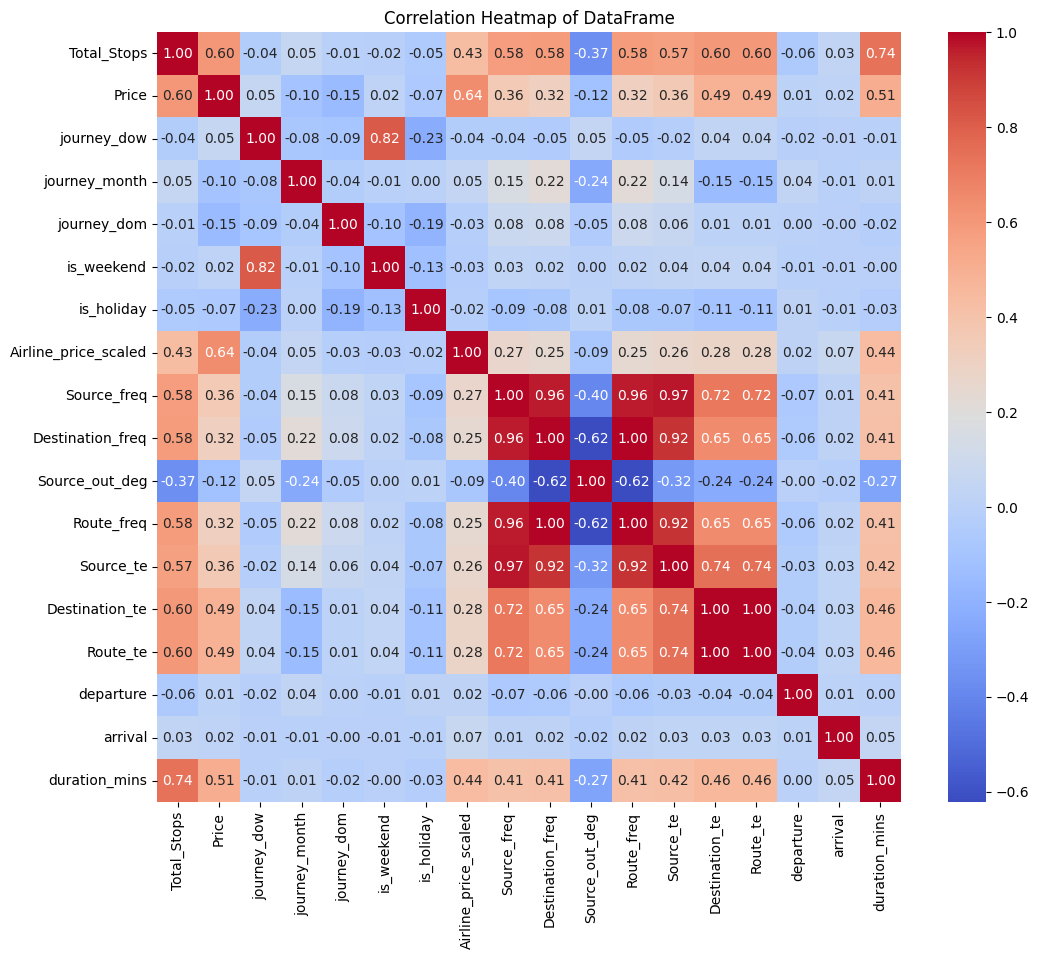

In [161]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of DataFrame')
plt.show()

# Train Test Split

In [163]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

x_train = train_df.drop(columns=['Price'])
y_train = train_df['Price']
x_test = test_df.drop(columns=['Price'])
y_test = test_df['Price']

train_df.shape, test_df.shape

((8546, 18), (2137, 18))

# RF Model

In [168]:
rf_model = RandomForestRegressor(
    n_estimators=1000,
    max_depth=25,
    min_samples_split=4,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.2s finished


RandomForestRegressor(max_depth=25, min_samples_split=4, n_estimators=1000,
                      n_jobs=-1, random_state=42, verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


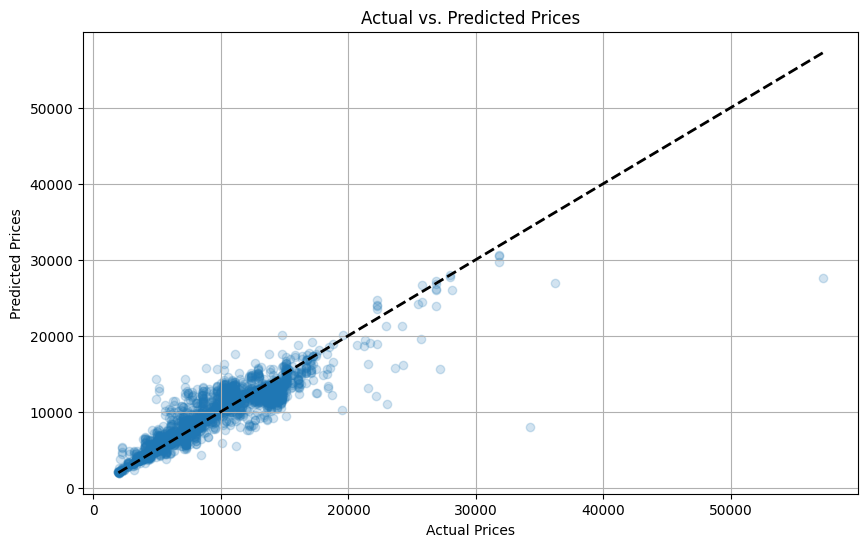

In [169]:
rf_predictions = rf_model.predict(x_test)

plot_predictions(y_test, rf_predictions)

In [170]:
r2_score(y_test, rf_predictions)

0.8254378993335405

In [171]:
mean_absolute_error(y_test, rf_predictions)

np.float64(1153.7655775407895)

# XGBoost Model

In [177]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=25,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50 # Stop if validation score doesn't improve
)

xgb_model.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=True)

[0]	validation_0-rmse:4564.39090
[1]	validation_0-rmse:4528.36440
[2]	validation_0-rmse:4492.94941
[3]	validation_0-rmse:4457.51370
[4]	validation_0-rmse:4422.35754
[5]	validation_0-rmse:4387.69073
[6]	validation_0-rmse:4353.35475
[7]	validation_0-rmse:4319.48542
[8]	validation_0-rmse:4286.07906
[9]	validation_0-rmse:4253.21272
[10]	validation_0-rmse:4220.51347
[11]	validation_0-rmse:4188.18312
[12]	validation_0-rmse:4156.11116
[13]	validation_0-rmse:4124.75557
[14]	validation_0-rmse:4093.53553
[15]	validation_0-rmse:4063.00773
[16]	validation_0-rmse:4032.49864
[17]	validation_0-rmse:4002.61182
[18]	validation_0-rmse:3973.06935
[19]	validation_0-rmse:3943.92236
[20]	validation_0-rmse:3915.22313
[21]	validation_0-rmse:3886.62149
[22]	validation_0-rmse:3858.38980
[23]	validation_0-rmse:3830.98239
[24]	validation_0-rmse:3803.83656
[25]	validation_0-rmse:3776.75080
[26]	validation_0-rmse:3749.97344
[27]	validation_0-rmse:3723.53068
[28]	validation_0-rmse:3697.53148
[29]	validation_0-rmse:3

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=25,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

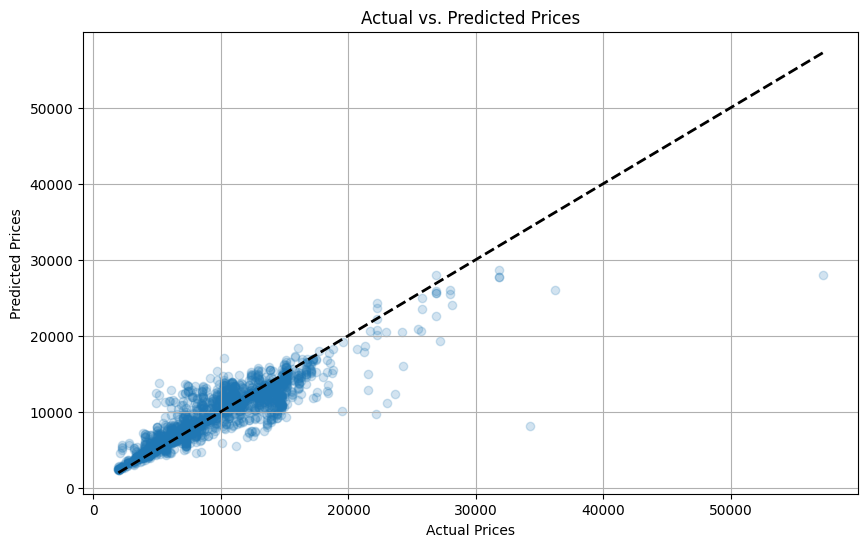

In [178]:
xgb_predictions = xgb_model.predict(x_test)

plot_predictions(y_test, xgb_predictions)

In [179]:
mean_absolute_error(y_test, xgb_predictions)

np.float64(1213.4691812732144)

In [180]:
r2_score(y_test, xgb_predictions)

0.8089084625244141

# Prophet